In [1]:
## Package setup
import grama as gr
import plotnine as pt
import pandas as pd
X = gr.Intention()

## Setup

---

Load trajectory data

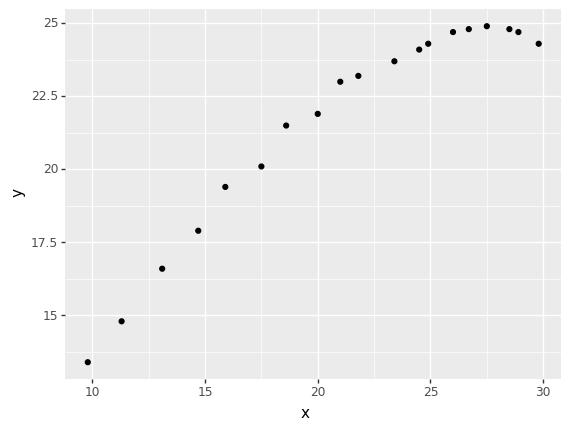

<ggplot: (8779368082013)>

In [2]:
from grama.data import df_trajectory_windowed

(
    pt.ggplot(df_trajectory_windowed, pt.aes("x", "y"))
    + pt.geom_point()
)

Load a trajectory model to fit


In [3]:
from grama.models import make_trajectory_linear
md_trajectory = make_trajectory_linear()
md_trajectory.printpretty()

model: Trajectory Model

  inputs:
    var_det:
      tau: [0.05, inf]
      u0: [0.1, inf]
      v0: [0.1, inf]
      t: [0, 600]
    var_rand:
    copula:
        None
  functions:
    x_trajectory: ['u0', 'v0', 'tau', 't'] -> ['x']
    y_trajectory: ['u0', 'v0', 'tau', 't'] -> ['y']


Fit trajectory model to data


In [4]:
md_fit = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_trajectory,
        method="SLSQP",
        uq_method="linpool",
    )
)

md_fit.printpretty()

... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']


        tau         u0         v0  tau_0  u0_0  v0_0  success  \
0  2.802249  18.792171  28.234804   0.05   0.1   0.1     True   

                                 message  n_iter       mse  
0  Optimization terminated successfully.      46  0.093358  
... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}
model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)
    var_rand:
      v0: (+0) norm, {'loc': 28.234804451034083, 'scale': 0.19741862486285683}
      u0: (+0) norm, {'loc': 18.792171042086544, 'scale': 0.17265602665164953}
      tau: (+0) norm, {'loc': 2.8022490911820617, 'scale': 0.12681159291740765}
    copula:
        Gaussian copula with correlations:
  var1 var2          corr
0   v0   u0  2.278278e-14
1   v0  tau -7.047707e-01
2   u0  tau -6.789706e-01
  functions:
    Trajectory Model: ['v0', 'u0', 'tau', 't'] -> ['y', 'x']


### Visualize estimated parameter distributions


Design runtime estimates unavailable; model has no timing data.
Calling plot_scattermat....


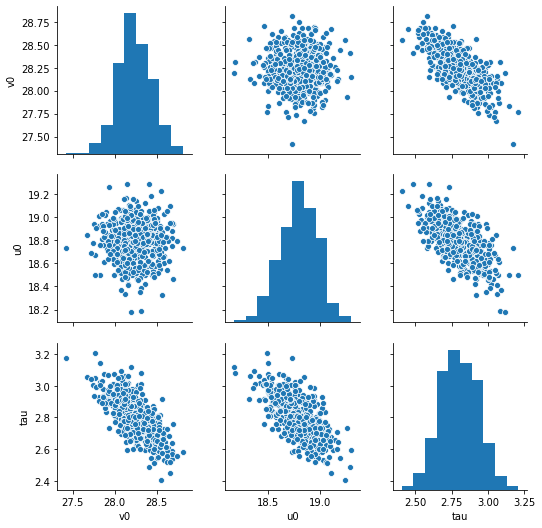

In [5]:
(
    md_fit
    >> gr.ev_monte_carlo(n=500, df_det="nom", skip=True)
    >> gr.pt_auto()
)

## Assess model


... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


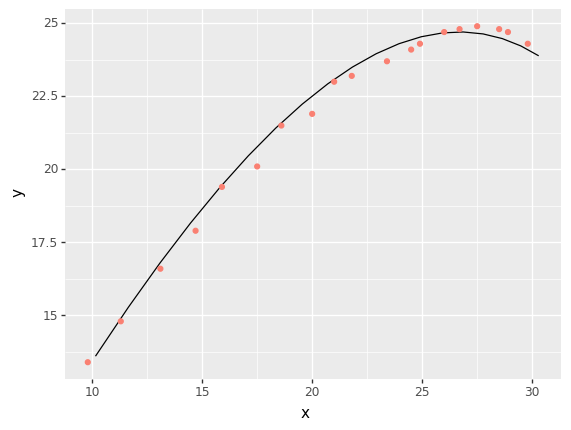

<ggplot: (8779365264017)>

In [6]:
# Nominal curve
df_nom = (
    md_fit
    >> gr.ev_nominal(df_det=df_trajectory_windowed)
)

(
    pt.ggplot(mapping=pt.aes("x", "y"))
    + pt.geom_line(data=df_nom)
    + pt.geom_point(data=df_trajectory_windowed, color="salmon")
)

## Assess model with ensemble of trajectories

In [7]:
# Nominal curve
df_lines = (
    md_fit
    >> gr.ev_monte_carlo(n=200, df_det=df_trajectory_windowed)
)

... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


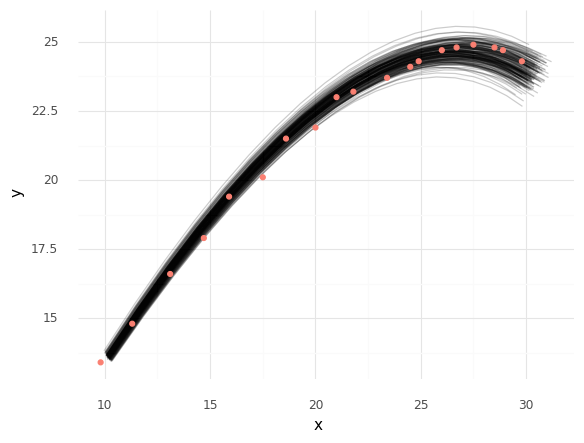

<ggplot: (8779370084345)>

In [8]:
# Visualize
plot = (
    pt.ggplot(mapping=pt.aes("x", "y"))
    + pt.geom_line(data=df_lines, mapping=pt.aes(group="u0"), alpha=1/5)
    + pt.geom_point(data=df_trajectory_windowed, color="salmon")
    + pt.theme_minimal()
)
plot

In [9]:
# Save the figure
plot.save("./trajectory-uncertainty-cone.png")